## Imports

In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
import math

# use fmDemodArctan and fmPlotPSD
from fmSupportLib import fmDemodArctan, fmPlotPSD, own_lfilter, lpCoeff, custom_fm_demod, logVector, bpFirwin, fmPll, delayBlock
from fmRRC import impulseResponseRootRaisedCosine
# for take-home add your functions


In [3]:
def upsample(y, upsampling_factor):
    if upsampling_factor == 1:
        return y

    original_size = len(y)
    y_extended = np.zeros(original_size * upsampling_factor)
    y_extended[::upsampling_factor] = y

    return y_extended

## Constants

In [4]:
rf_Fs = 2.4e6
rf_Fc = 100e3
rf_taps = 101
rf_decim = 10

audio_taps = 101
audio_Fc = 16e3
audio_decim = 5
audio_Fs = 48e3

rds_bpf_fc_low = 54e3
rds_bpf_fc_high = 60e3
rds_bpf_taps = 101

rds_lpf_fc = 3e3
rds_lpf_taps = 101

rds_rrc_taps = 151

rds_upsampling_factor = 19
rds_downsampling_factor = 80
rds_decim = rds_downsampling_factor/rds_upsampling_factor

rds_squared_bpf_fc_low = 113.5e3
rds_squared_bpf_fc_high = 114.5e3
rds_carrier_frequency = 114e3
rds_squared_bpf_taps = 101

## State Variables (useless in single pass)

In [5]:
state_i_lpf_100k = np.zeros(rf_taps-1)
state_q_lpf_100k = np.zeros(rf_taps-1)
rds_filt_state_bpf = np.zeros(rds_squared_bpf_taps-1)
rds_filt_state_apf = np.zeros(int((rds_bpf_taps-1)/2))
rds_filt_state_lpf = np.zeros(rds_lpf_taps-1)
state_phase = 0
state_i_custom = np.float64(0.0)
state_q_custom = np.float64(0.0)

# INIITIAL PLL STATES
pll_state_integrator = 0.0
pll_state_phaseEst = 0.0
pll_state_feedbackI = 1.0
pll_state_feedbackQ = 0.0
pll_state_trigOffset = 0
pll_state_lastNco = 1.0

pll_state_integrator_q =  0.0
pll_state_phaseEst_q =  0.0
pll_state_feedbackI_q =  1.0
pll_state_feedbackQ_q =  0.0
pll_state_trigOffset_q =  0
pll_state_lastNco_q =  1.0

## Read In Raw Data

In [6]:
in_fname = "../data/samples9.raw"

raw_data = np.fromfile(in_fname, dtype='uint8')
print("Read raw RF data from \"" + in_fname + "\" in unsigned 8-bit format")
# IQ data is normalized between -1 and +1 in 32-bit float format
iq_data = (np.float32(raw_data) - 128.0)/128.0
print("Reformatted raw RF data to 32-bit float format (" + str(iq_data.size * iq_data.itemsize) + " bytes)")

# set up the subfigures for plotting
# subfig_height = np.array([0.8, 2, 1.6])
# plt.rc('figure', figsize=(7.5, 7.5))	
# fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, gridspec_kw={'height_ratios': subfig_height})
# fig.subplots_adjust(hspace = .6)

Read raw RF data from "../data/samples9.raw" in unsigned 8-bit format
Reformatted raw RF data to 32-bit float format (96000000 bytes)


## Calculate the filter coefficients

In [7]:
rf_coeff = signal.firwin(rf_taps, rf_Fc/(rf_Fs/2), window=('hann'))

audio_coeff = signal.firwin(audio_taps, audio_Fc/((rf_Fs/rf_decim)/2), window=('hann'))

rds_bpf_coeff = bpFirwin((rf_Fs/rf_decim), 
                            rds_bpf_fc_low, 
                            rds_bpf_fc_high, 
                            rds_bpf_taps)

rds_squared_bpf_coeff = bpFirwin((rf_Fs/rf_decim), 
                                    rds_squared_bpf_fc_low, 
                                    rds_squared_bpf_fc_high, 
                                    rds_squared_bpf_taps)

rds_lpf_coeff = signal.firwin(rds_lpf_taps, rds_lpf_fc/((rf_Fs/rf_decim)/2), window=('hann'))



rds_rrc_coeff = impulseResponseRootRaisedCosine(rf_Fs/(rf_decim*rds_decim), rds_rrc_taps)


## RF Front End

In [8]:
i_filt = signal.lfilter(rf_coeff, 1.0, iq_data[::2])
q_filt = signal.lfilter(rf_coeff, 1.0, iq_data[1::2])

i_ds = i_filt[::rf_decim]
q_ds = q_filt[::rf_decim]

fm_demod, dummy = fmDemodArctan(i_ds, q_ds)

## Audio check

In [9]:
# audio_filt = signal.lfilter(audio_coeff, 1.0, fm_demod[0])
# audio_data = audio_filt[::audio_decim] # to be updated by you during in-lab (same code for takehome)
# out_fname = "../data/fmRdsBasic_mono.wav"
# wavfile.write(out_fname, int(audio_Fs), np.int16((audio_data/2)*32767))

## RDS Data Extraction

### In phase

In [10]:
# Bandpass filter
rds_filt = signal.lfilter(rds_bpf_coeff, 1.0, fm_demod)

# square signal
rds_filt_squared = rds_filt*rds_filt

rds_filt_carrier = signal.lfilter(rds_squared_bpf_coeff, 1.0, rds_filt_squared)

ncoOut_inPhase, pll_state_integrator, pll_state_phaseEst, pll_state_trigOffset, pll_state_lastNco = fmPll(
			rds_filt_carrier, 
			rds_carrier_frequency, 
			rf_Fs/rf_decim, 
			pll_state_integrator, 
			pll_state_phaseEst,
			pll_state_feedbackI,
			pll_state_feedbackQ,
			pll_state_trigOffset, 
			pll_state_lastNco, 
			ncoScale=0.5,
			normBandwidth=0.0025)

# plt.plot(ncoOut[10000:10100])
# plt.plot(100*rds_filt_carrier[10000:10100])
# plt.show()

### Quadrature phase

In [11]:
# Bandpass filter
rds_filt = signal.lfilter(rds_bpf_coeff, 1.0, fm_demod)

# square signal
rds_filt_squared = rds_filt*rds_filt

rds_filt_carrier = signal.lfilter(rds_squared_bpf_coeff, 1.0, rds_filt_squared)

ncoOut_qPhase, pll_state_integrator_q, pll_state_phaseEst_q, pll_state_trigOffset_q, pll_state_lastNco_q = fmPll(
			rds_filt_carrier, 
			rds_carrier_frequency, 
			rf_Fs/rf_decim, 
			pll_state_integrator_q, 
			pll_state_phaseEst_q,
			pll_state_feedbackI_q,
			pll_state_feedbackQ_q,
			pll_state_trigOffset_q, 
			pll_state_lastNco_q, 
			ncoScale=0.5,
			normBandwidth=0.0025,
            phaseAdjust=math.pi/4)

## All Pass filter rds data

In [12]:
rds_filt_delayed, rds_filt_state_apf = delayBlock(rds_filt, rds_filt_state_apf)


## RDS Demodulation

### In phase


In [13]:
# Mixer
rds_mixed = rds_filt_delayed * ncoOut_inPhase[:-1]

rds_mixed_lfiltered = signal.lfilter(rds_lpf_coeff, 1.0, rds_mixed)

rds_upsampled = upsample(rds_mixed_lfiltered, rds_upsampling_factor)

rds_upsampled_lfilterd = signal.lfilter(rds_lpf_coeff, 1.0, rds_upsampled)

rds_resampled = rds_upsampled_lfilterd[::rds_downsampling_factor]

rds_rrcfiltered = signal.lfilter(rds_rrc_coeff, 1.0, rds_resampled)

### Quadrature phase

In [14]:
# Mixer
rds_mixed = rds_filt_delayed * ncoOut_inPhase[:-1]

rds_mixed_lfiltered = signal.lfilter(rds_lpf_coeff, 1.0, rds_mixed)

rds_upsampled = upsample(rds_mixed_lfiltered, rds_upsampling_factor)

rds_upsampled_lfilterd = signal.lfilter(rds_lpf_coeff, 1.0, rds_upsampled)

rds_resampled = rds_upsampled_lfilterd[::rds_downsampling_factor]

rds_rrcfiltered = signal.lfilter(rds_rrc_coeff, 1.0, rds_resampled)

## Sampling Playground


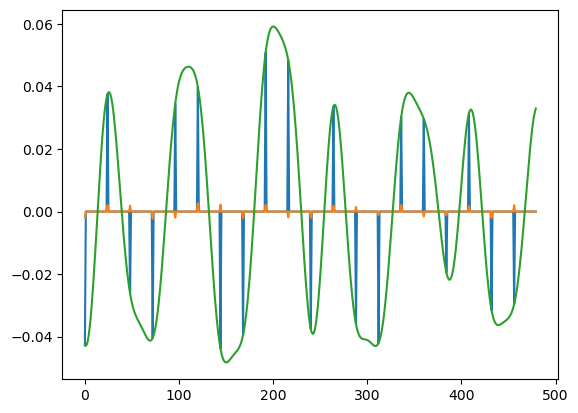

In [40]:
samples_per_symbol = 24
symbols_per_window = 20
winsize = (samples_per_symbol*symbols_per_window)

winsize

new_win = 355

sample_window_start = 11995+samples_per_symbol*symbols_per_window*new_win
no_rrc_sample_window = rds_resampled[sample_window_start:sample_window_start+winsize]
rrc_sample_window = rds_rrcfiltered[sample_window_start:sample_window_start+winsize]

samples = np.ones(symbols_per_window)
samples = upsample(samples, samples_per_symbol)

samples_no_rrc = samples * no_rrc_sample_window
samples_rrc = samples * rrc_sample_window

plt.plot(samples_rrc)
plt.plot(samples_no_rrc)
plt.plot(rrc_sample_window)
plt.show()


sampling start 23
480
[1 0 1 0 1 1 0 1 1 0]


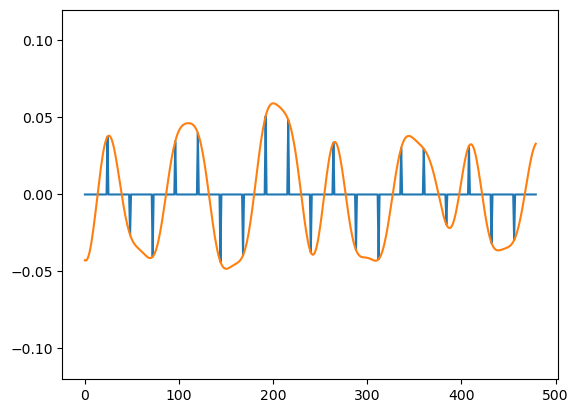

In [41]:
def sampling_start_adjust(block, samples_per_symbol):
    abs_min_idx = 0
    abs_min = abs(block[abs_min_idx])
    for i in range(0, len(block)):
        diff = abs(block[i])
        if diff < abs_min:
            abs_min = diff
            abs_min_idx = i

    return i % samples_per_symbol

samples_per_symbol = 24
symbols_per_window = 20
winsize = (samples_per_symbol*symbols_per_window)

new_win = 0
sample_window_off = 0

sample_window = 1222+samples_per_symbol*symbols_per_window*new_win
sampling_start = sampling_start_adjust(rds_resampled[sample_window:sample_window+winsize], samples_per_symbol)
print("sampling start", sampling_start)
samples = np.ones(symbols_per_window)
samples_upsampled = upsample(samples, samples_per_symbol)[:-(sampling_start+1)]

samples = np.concatenate((np.zeros(sampling_start+1), samples_upsampled))

rrc_sample_window = rds_rrcfiltered[sample_window_start:sample_window_start+winsize]

samples_rrc = samples * rrc_sample_window

bool_array = np.empty(int(symbols_per_window/2), dtype=int)
index = 0
errors = 0

print(winsize)

for i in range(sampling_start, winsize, 2*samples_per_symbol):
    if rrc_sample_window[i] > 0 and rrc_sample_window[i+samples_per_symbol] < 0:
        bool_array[index] = 1
    elif rrc_sample_window[i] < 0 and rrc_sample_window[i+samples_per_symbol] > 0:
        bool_array[index] = 0
    else:
        bool_array[index] = -1
    index = index + 1    

print(bool_array)

plt.plot(samples_rrc)
plt.plot(rrc_sample_window)
plt.ylim(-0.12, 0.12)
plt.show()
